In [20]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs

centers = np.array([[-5,7],
                  [0,0],
                  [10,10]])
X, y = make_blobs(n_samples=1000, centers=centers, n_features=2, random_state=0)

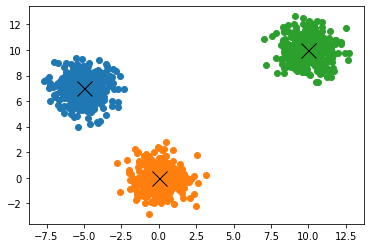

In [21]:
for i in range(3):
    plt.plot(X[y==i,0], X[y==i,1], 'o')
for i in range(3):
    plt.plot(centers[i,0], centers[i,1], 'kx', markersize = 15)

# GMM

Algorithm
![](kmeans.png)

EM
![](EM.png)

In [37]:
K = 3
m = np.random.rand(K,X.shape[1])* 10

me = m.reshape( m.shape[0], -1, m.shape[1])
XE = X.reshape(-1, *X.shape)

me.shape, XE.shape

((3, 1, 2), (1, 1000, 2))

In [38]:
D = XE - me
D.shape

(3, 1000, 2)

In [39]:
D.T.shape

(2, 1000, 3)

In [54]:
S = np.einsum('ijk,ijb->ikb',D,D) /(X.shape[0] - 1)
S

array([[[40.35685468,  8.87608565],
        [ 8.87608565, 47.92259547]],

       [[70.17966412, 14.71053877],
        [14.71053877, 19.00266975]],

       [[42.03132552,  6.34153515],
        [ 6.34153515, 35.54780416]]])

In [49]:
D[0].T.dot(D[0])/(X.shape[0] - 1)

array([[40.35685468,  8.87608565],
       [ 8.87608565, 47.92259547]])

In [55]:
D[1].T.dot(D[1])/(X.shape[0] - 1)

array([[70.17966412, 14.71053877],
       [14.71053877, 19.00266975]])

In [57]:
m, S

(array([[2.25580584, 0.26386706],
        [7.1313815 , 6.11274807],
        [3.07149584, 1.56721697]]),
 array([[[40.35685468,  8.87608565],
         [ 8.87608565, 47.92259547]],
 
        [[70.17966412, 14.71053877],
         [14.71053877, 19.00266975]],
 
        [[42.03132552,  6.34153515],
         [ 6.34153515, 35.54780416]]]))

In [59]:
prior = np.array([1/K] * K)
prior

array([0.33333333, 0.33333333, 0.33333333])

In [63]:
from scipy.stats import multivariate_normal

def model(x, mu, std, prior, K =3):
    results = np.array([multivariate_normal.pdf(x, mu[i], std[i]) *  prior[i] 
                        for i in range(K)
                        for x in X
                       ])
    return results/results.sum()

In [64]:
x = np.array([1,1])
model(x = x, mu = m, std = S, prior = prior, K =3)

array([0.36397212, 0.23354464, 0.40248324])

In [83]:
results = np.array([[multivariate_normal.pdf(x, m[i], S[i]) *  prior[i] 
                    for i in range(K)]
                    for x in X
                   ])
h = results/results.sum(keepdims =True, axis = 1)

In [84]:
h

array([[0.29082507, 0.3806219 , 0.32855304],
       [0.29450092, 0.3753729 , 0.33012618],
       [0.18814048, 0.59449286, 0.21736667],
       ...,
       [0.42249538, 0.14632292, 0.43118171],
       [0.37974837, 0.20513024, 0.41512139],
       [0.19875755, 0.57511271, 0.22612974]])

In [85]:
m

array([[2.25580584, 0.26386706],
       [7.1313815 , 6.11274807],
       [3.07149584, 1.56721697]])

In [91]:
new_m = np.array([(X * h[:,i:(i+1)]).mean(axis = 0) for i in range(K)])
new_m

array([[0.0725228 , 1.25646777],
       [1.42468944, 2.93569315],
       [0.14105128, 1.46593579]])

In [92]:
i = 2
(X * h[:,i:(i+1)]).mean(axis = 0)

array([0.14105128, 1.46593579])

In [95]:
new_S = np.array([np.cov((X * h[:,i:(i+1)]).T) for i in range(K)])
new_S

array([[[ 1.80111317, -0.14197499],
        [-0.14197499,  0.97364348]],

       [[12.20843164,  6.99847081],
        [ 6.99847081,  6.5758221 ]],

       [[ 2.46735066, -0.04389295],
        [-0.04389295,  1.23890711]]])

In [97]:
new_prior = h.mean(axis = 0)
new_prior

array([0.28774097, 0.39332565, 0.31893337])

# GMM

In [177]:
K = 3
m = np.random.rand(K,X.shape[1])* 10

me = m.reshape( m.shape[0], -1, m.shape[1])
XE = X.reshape(-1, *X.shape)

D = XE - me
S = np.einsum('ijk,ijb->ikb',D,D) /(X.shape[0] - 1)
prior = np.array([1/K] * K)
print(m)

[[8.36793848 9.11619277]
 [4.37252536 5.79137974]
 [9.01377763 4.2698103 ]]


In [178]:
for i in range(10):
    results = np.array([[ multivariate_normal.pdf(x, m[i], S[i]) * prior[i]
                        for i in range(K)]
                        for x in X
                       ])
    #results = np.abs(results.sum(keepdims =True, axis = 1)) -  results
    h = results/results.sum(keepdims =True, axis = 1)

    D = XE - me
    Dh = np.einsum('ijk,ji->ijk',D,h)
    #m = np.array([(X * h[:,i:(i+1)]).mean(axis = 0) for i in range(K)])
    m = Dh.mean(axis = 1)
    me = new_m.reshape(m.shape[0], -1, m.shape[1])
    
    #S = np.array([np.cov((D[i] * h[:,i:(i+1)]).T)/(X.shape[0] - 1) for i in range(K)])
    S = np.einsum('ijk,ijb->ikb',Dh,Dh) /(X.shape[0] - 1)
    prior = h.mean(axis = 0)
    print(S)

[[[6.44363606 2.07750415]
  [2.07750415 1.53701408]]

 [[8.01973815 2.24848398]
  [2.24848398 3.48633892]]

 [[8.55325282 0.24694514]
  [0.24694514 1.30164326]]]
[[[ 4.90968295e-02  4.02661779e-02]
  [ 4.02661779e-02  1.55746411e-01]]

 [[ 4.00428446e+01  1.43769080e+01]
  [ 1.43769080e+01  2.40310855e+01]]

 [[ 4.73594220e-02 -2.55037766e-03]
  [-2.55037766e-03  5.16950817e-02]]]
[[[1.30675211e-02 3.73097670e-02]
  [3.73097670e-02 1.32612707e-01]]

 [[4.07202628e+01 1.44955787e+01]
  [1.44955787e+01 2.56170067e+01]]

 [[6.74022762e-03 1.19061916e-02]
  [1.19061916e-02 2.94775283e-02]]]
[[[4.81417746e-03 1.58315678e-02]
  [1.58315678e-02 5.31804428e-02]]

 [[4.07805478e+01 1.46795278e+01]
  [1.46795278e+01 2.63457490e+01]]

 [[5.42757960e-04 1.50237043e-03]
  [1.50237043e-03 4.24550796e-03]]]
[[[1.32134088e-03 4.35936462e-03]
  [4.35936462e-03 1.43999791e-02]]

 [[4.07994992e+01 1.47515157e+01]
  [1.47515157e+01 2.66245858e+01]]

 [[1.04489105e-11 2.90882099e-11]
  [2.90882099e-11 8.09

LinAlgError: singular matrix

In [147]:
S

array([[[ 0.00109551, -0.00033211],
        [-0.00033211,  0.00089251]],

       [[ 0.00375408,  0.00090099],
        [ 0.00090099,  0.00165833]],

       [[ 0.01174013,  0.00592408],
        [ 0.00592408,  0.00576473]]])

In [148]:
h

array([[0.2435316 , 0.33599172, 0.42047668],
       [0.24064815, 0.30533248, 0.45401937],
       [0.09531782, 0.24427125, 0.66041093],
       ...,
       [0.45375158, 0.30994362, 0.2363048 ],
       [0.38110313, 0.33797778, 0.28091909],
       [0.09901753, 0.23723337, 0.66374911]])

In [143]:
D

array([[[-6.45738999,  4.20811012],
        [-3.64478468,  6.02828527],
        [ 9.09536748,  9.84470577],
        ...,
        [ 0.19827464, -2.42004235],
        [ 1.2227604 , -0.99411277],
        [ 8.61876008,  9.97434913]],

       [[-6.77651915,  2.73177858],
        [-3.96391384,  4.55195372],
        [ 8.77623832,  8.36837423],
        ...,
        [-0.12085451, -3.89637389],
        [ 0.90363124, -2.47044431],
        [ 8.29963093,  8.49801759]],

       [[-6.55001327,  4.14196077],
        [-3.73740796,  5.96213592],
        [ 9.0027442 ,  9.77855642],
        ...,
        [ 0.10565137, -2.4861917 ],
        [ 1.13013712, -1.06026212],
        [ 8.52613681,  9.90819978]]])

In [144]:
D.shape

(3, 1000, 2)

In [150]:
h.shape

(1000, 3)

In [156]:
DM = np.einsum('ijk,ji->ijk',D,h)
DM

array([[[-1.57257853,  1.0248078 ],
        [-0.8771107 ,  1.45069571],
        [ 0.86695062,  0.93837592],
        ...,
        [ 0.08996743, -1.09809804],
        [ 0.46599782, -0.37885949],
        [ 0.8534083 ,  0.98763537]],

       [[-2.27685433,  0.91785498],
        [-1.21031164,  1.38985932],
        [ 2.14378273,  2.04415325],
        ...,
        [-0.03745809, -1.20765624],
        [ 0.30540728, -0.83495529],
        [ 1.96894938,  2.01601331]],

       [[-2.75412782,  1.7415979 ],
        [-1.6968556 ,  2.70692518],
        [ 5.94551063,  6.45786549],
        ...,
        [ 0.02496592, -0.58749903],
        [ 0.31747709, -0.29784787],
        [ 5.65921571,  6.57655878]]])

In [155]:
D[0]  * h[:,0:1]

array([[-1.57257853,  1.0248078 ],
       [-0.8771107 ,  1.45069571],
       [ 0.86695062,  0.93837592],
       ...,
       [ 0.08996743, -1.09809804],
       [ 0.46599782, -0.37885949],
       [ 0.8534083 ,  0.98763537]])

In [157]:
DM.mean(axis = 1)

array([[-0.19977406,  0.59722401],
       [ 0.19229754,  0.8207427 ],
       [ 1.0968421 ,  2.37964631]])